In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import tensorflow as tf
import torch.utils.data
import joblib
from torch.utils.data import TensorDataset
from transformers import TFRobertaModel, RobertaTokenizer
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [ ]:
from google.colab import files
upload=files.upload()

Saving dataset.xlsx to dataset.xlsx


In [ ]:
df=pd.read_excel("dataset.xlsx")
category_map={
    "Knowledge": 0,
    "Comprehension": 1,
    "Application": 2,
    "Analysis": 3,
    "Synthesis": 4,
    "Evaluation": 5
}
df["category"]=df["category"].map(category_map)
df.to_excel("dataset.xlsx",index=False)

In [ ]:
df.head()

,category,text
0,0,List two reference parameters in the setHour ...
1,0,Explain briefly the meaning of the following ...
2,0,Label the parts of the diagram
3,0,"4. Based on the above dataType class, list all..."
4,0,5. Define morphology


In [ ]:
df['category'].value_counts()

5    263
4    250
0    226
1    223
3    223
2    214
Name: category, dtype: int64

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
token= tokenizer.encode_plus(
    df['text'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)
token.pop('token_type_ids', None)

In [ ]:
X_input_ids= np.zeros((len(df),256))
X_attn_masks= np.zeros((len(df),256))

In [ ]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text['input_ids']
        masks[i, :] = tokenized_text['attention_mask']
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)


0it [00:00, ?it/s]

In [ ]:
labels= np.zeros((len(df),6))
labels.shape

(1399, 6)

In [ ]:
labels[np.arange(len(df)), df['category'].values] = 1

In [ ]:
labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [ ]:
def BloomsDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(BloomsDatasetMapFunction)


In [ ]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>

In [ ]:
p=0.8
train_size=int((len(df)//16*p))

In [ ]:
train_dataset=dataset.take(train_size)
val_dataset=dataset.skip(train_size)
len(train_dataset),len(val_dataset)

(69, 18)

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

roberta_embds = roberta_model(input_ids, attention_mask=attn_masks)[1]
intermediate_layer = tf.keras.layers.Dense(256, activation='relu', name='roberta_intermediate_layer')(roberta_embds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', name='roberta_output_layer')(intermediate_layer)

Blooms_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
Blooms_model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
Blooms_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

for epoch in range(5):
    # Train the model for one epoch
    hist = Blooms_model.fit(
        train_dataset,
        validation_data=val_dataset
    )
    # Evaluate the model on the validation set
    val_loss, val_acc = Blooms_model.evaluate(val_dataset, verbose=0)
    print(f"Epoch {epoch + 1}: Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
    y_true, y_pred = [], []
    for x, y in val_dataset:
        y_true.append(tf.argmax(y, axis=1).numpy())
        y_pred.append(tf.argmax(Blooms_model.predict(x), axis=1).numpy())
# Concatenate predictions and true labels for all batches
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Compute confusion matrix and classification report for the entire validation set
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

69/69 [==============================] - 3965s 57s/step - loss: 1.7393 - accuracy: 0.2527 - val_loss: 1.2806 - val_accuracy: 0.5556
Epoch 1: Val Loss: 1.344, Val Acc: 0.538
1/1 [==============================] - 16s 16s/step
Confusion Matrix:
[[42  1  1  0  0  7]
 [14  4  3  1  5 16]
 [ 3  0 13  1 12  8]
 [10  1  8 13  2 15]
 [ 2  0  6  0 38  8]
 [ 6  0  2  2  3 41]]
Classification Report:
(0.5765154772701212, 0.5243055555555556, 0.48351793893931205, None)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
joblib.dump(tokenizer,'final_roberta_tokenizer.joblib')
Blooms_model.save('final_roberta_model.h5')

In [5]:
tokenizer = joblib.load('/content/drive/My Drive/final_roberta_tokenizer.joblib')
model = tf.keras.models.load_model('/content/drive/My Drive/final_roberta_model.h5', custom_objects={'TFRobertaModel': TFRobertaModel})

In [6]:
def classify_question(question):

    encoded_question = tokenizer.encode_plus(
        question,
        max_length=256,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='tf'
    )
    input_ids = encoded_question['input_ids']
    attn_mask = encoded_question['attention_mask']


    prediction = model.predict([input_ids, attn_mask])
    predicted_class_num = tf.argmax(prediction, axis=1).numpy()[0]



    class_names = ["Knowledge", "Comprehension", "Application", "Analysis", "Synthesis", "Evaluation"]
    predicted_class_name = class_names[predicted_class_num]

    if question=="" or question.isspace():
      return("Please enter a valid question!!")

    else:
      return(predicted_class_name)

In [7]:
from collections import Counter
tm=int(input("Enter total marks:"))
tt=int(input("Enter total time for attempting the question paper in minutes:"))
rem_marks=tm
rem_time=tt
marks=0
difficulty=[]
level=[]
while rem_marks>0:
    ques=input("Enter your question:")
    level_name = classify_question(ques)
    time=int(input("Enter estimated time to attempt this question:"))
    if(time>rem_time):
      print("Time exceeded!! Remaining time limit: ",rem_time)
      continue
    else:
      marks=int(input("Enter marks of question:"))
      if(marks>rem_marks):
        print("Marks exceeded!! Remaining marks limit: ",rem_marks)
        continue
      else:
        rem_time-=time
        diff=input("Enter difficulty level:")
        difficulty.append(diff)
        level.append(level_name)
        rem_marks-=marks
        print(f"The level of the question is: {level_name}")

c1=Counter(difficulty)
c2=Counter(level)

Enter total marks:10
Enter total time for attempting the question paper in minutes:15
Enter your question:create an activity diagram 
1/1 [==============================] - 16s 16s/step
Enter estimated time to attempt this question:10
Enter marks of question:6
Enter difficulty level:medium
The level of the question is: Application
Enter your question:can you design an original system for identifying and mitigating bias in natural language processing models
1/1 [==============================] - 1s 1s/step
Enter estimated time to attempt this question:4
Enter marks of question:4
Enter difficulty level:medium
The level of the question is: Synthesis


                                                             QUESTION PAPER ANALYSIS REPORT                                     
----------------------------------------------------------------------------------------------------------------------------------------------------------------------*----------------------------
Extra Time remaining in minutes: 1
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Level wise analysis of Question Paper


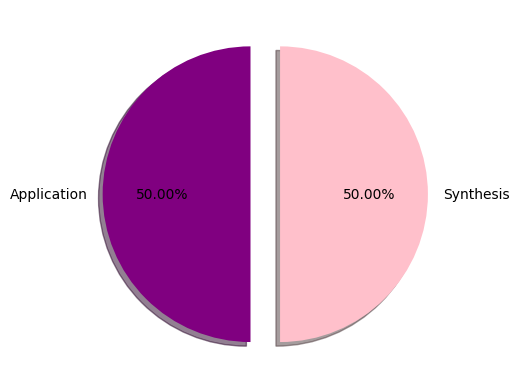

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Difficulty wise analysis of Question Paper


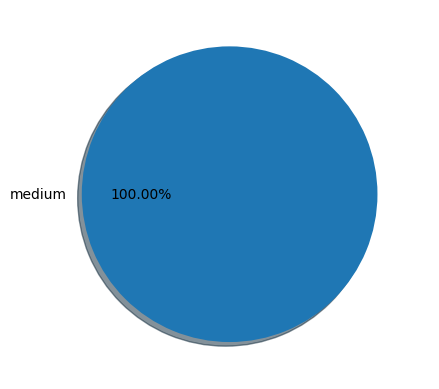

In [8]:
import matplotlib.pyplot as plt
print("                                                             QUESTION PAPER ANALYSIS REPORT                                     ")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------*----------------------------")
length=len(c2)
length1=len(c1)
print("Extra Time remaining in minutes:",rem_time)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
colors=['purple', 'pink', 'cyan','red','blue','brown']
ques_values =list(c2.values() )
ques_levels=list(c2.keys())
plt.pie(ques_values,labels=ques_levels,colors=colors, startangle=90, shadow=True,explode=(0.1,)*length, autopct='%1.2f%%')
print("Level wise analysis of Question Paper")
plt.show()
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
diff_values =list(c1.values() )
difficulty_levels=list(c1.keys())
plt.pie(diff_values,labels=difficulty_levels,shadow=True,explode=(0.1,)*length1, autopct='%1.2f%%')
print("Difficulty wise analysis of Question Paper")
plt.show()